In [ ]:
from openql import openql as ql

platform = ql.Platform('myPlatform', 'none')

print(platform.dump_info())

In [ ]:
import qxelarator

from functools import reduce

import os

import matplotlib.pyplot as plt

# Some housekeeping:
# - the directory where the cQASM file is stored:
ql.set_option('output_dir', 'output')
# - set the logging level to 'information'
ql.set_option('log_level', 'LOG_INFO')

# We'll use three qbits
nqubits = 3

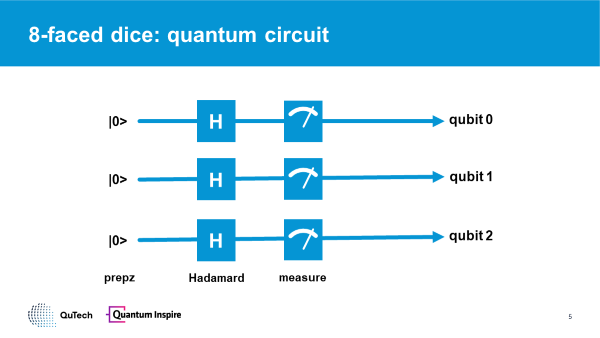

In [ ]:
def dice_compile():
    # Define the platform. We'll use the default platform 'none'
    platform = ql.Platform('myPlatform', 'none')
    # Define the program 'Dice'. The program will be run on 'platform', and it will use 3 qbits
    dice = ql.Program('Dice', platform, nqubits)

    # The following four lines are 'magic' to make sure OpenQL produces cQASM 1.0
    # After QXelarator is upgraded to cQASM 1.2, these lines (should) become obsolete
    dice.get_compiler().set_option('initialqasmwriter.cqasm_version', '1.0')
    dice.get_compiler().set_option('initialqasmwriter.with_metadata', 'no')
    dice.get_compiler().set_option('scheduledqasmwriter.cqasm_version', '1.0')
    dice.get_compiler().set_option('scheduledqasmwriter.with_metadata', 'no')
    
    # An OpenQL program consists of kernels.
    # Here we have three kernels: preparation, hadamard, anda measurement
    prep  = ql.Kernel('prep',  platform, nqubits)
    hadam = ql.Kernel('hadam', platform, nqubits)
    meas  = ql.Kernel('meas',  platform, nqubits)

    for q in range(nqubits):
        prep.gate('prepz', [q])

    for q in range(nqubits):
        hadam.gate('h', [q])

    for q in range(nqubits):
        meas.gate('measure', [q])

    # Attach the kernels to the program Dice in the proper order
    dice.add_kernel(prep)
    dice.add_kernel(hadam)
    dice.add_kernel(meas)
    
    # Finally, compile the program dice
    dice.compile()

In [ ]:
dice_compile()
with open('output/Dice.qasm') as file:
    res = file.read()
print(res)

In [ ]:
def dice_execute_singleshot():
    # Define a qxelarator
    qx = qxelarator.QX()

    # Load the cQASM representation of the quantum circuit into qxelarator
    qx.set('output/Dice.qasm')

    # execute simulate (once!)
    qx.execute()

    # get the measurement results
    res = [int(qx.get_measurement_outcome(q)) for q in range(nqubits)]
    print(f'"Raw" simulation result: {res}')

    # convert the measurement results from 3 qubits to dice face value
    dice_face = reduce(lambda x, y: 2*x+y, res, 0) + 1
    print(f'Dice face : {dice_face}')


def dice_execute_multishot_v1(ntests):

    # Define a qxelarator
    qx = qxelarator.QX()

    # Load the cQASM representation of the quantum circuit into qxelarator
    qx.set('output/Dice.qasm')
    
    dice_faces = []

    for i in range(ntests):
        # execute simulate (once!)
        qx.execute()
        # get the measurement results
        res = [int(qx.get_measurement_outcome(q)) for q in range(nqubits)]
        # for q in range(nqubits):
        #     print(f'qx.get_measurement_outcome(q)={int(qx.get_measurement_outcome(q))}')
        
        # convert the measurement results from 3 qubits to dice face value
        dice_face = reduce(lambda x, y: 2*x+y, res, 0) + 1
        dice_faces.append(dice_face)

    print(dice_faces)
    plot_histogram(dice_faces)

def plot_histogram(dice_faces):
    plt.hist(dice_faces, bins=8, color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Dice Face',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Histogram',fontsize=15)
    plt.show()
    plt.savefig('hist.png')

dice_compile()


In [ ]:
dice_execute_singleshot()

In [ ]:
dice_execute_multishot_v1(100)

In [ ]:
import json

def result_to_distr(simulation_result):
    results = simulation_result['results']
    return  [results.get('0000000000', 0.0), results.get('0000000001', 0.0),
             results.get('0000000010', 0.0), results.get('0000000011', 0.0),
             results.get('0000000100', 0.0), results.get('0000000101', 0.0),
             results.get('0000000110', 0.0), results.get('0000000111', 0.0)
             ]

def dice_execute_multishot_v2(ntests):
    qx = qxelarator.QX()
    qx.set('output/Dice.qasm')

    # Set the file where the simulation output is stored
    qx.set_json_output_path('output/Dice.json')
    qx.execute(ntests)
    with open('output/Dice.json') as file:
        res = json.loads(file.read())
    outcome = result_to_distr(res)
    print(res)
    print(outcome)
    
    plt.bar([1,2,3,4,5,6,7,8],outcome)
    plt.xlabel('Dice Face',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title('Histogram',fontsize=15)
    plt.show()

dice_execute_multishot_v2(1000)